[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [4]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [5]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [6]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [7]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [8]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other fascinating marine mammals worth learning about:\n\n1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and are often studied for their communication skills and complex social structures.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are generally smaller and have different characteristics, such as rounded snouts and spade-shaped teeth.\n\n3. **Seals**: These pinnipeds are adapted for life both in water and on land. Common species include the harbor seal and the gray seal.\n\n4. **Sea Lions**: Distinguished by their external ear flaps and ability to "walk" on land using their large flippers, sea lions are highly social animals.\n\n5. **Walruses**: Known for their large tusks and whiskers, walruses are social animals that live primarily in the Arctic and are dependent on sea ice.\n\n6. **Manatees and Dugongs**: Often referred to as "sea cows," these gentle

We can run our chat model in a simple graph with `MessagesState`.

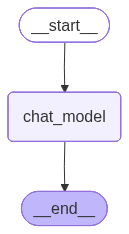

In [9]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there's a fascinating array of other ocean mammals you can explore. Here are a few you might find interesting:

1. **Dolphins**: Closely related to whales, dolphins are known for their intelligence, complex behaviors, and social structures. They are found in oceans and seas worldwide.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different physical characteristics. They are typically shyer than dolphins.

3. **Seals**: These are pinnipeds, meaning "fin-footed," and are divided into different families. True seals (earless seals) and fur seals/sea lions (eare

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

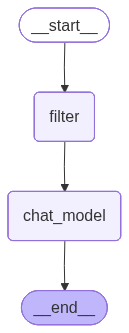

In [11]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might want to learn about:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are closely related to whales and can be found in oceans around the world. They are known for their playful behavior and complex communication.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different physical characteristics, such as spade-shaped teeth and shorter beaks. They are more reserved compared to dolphins.

3. **Seals and Sea Lions**: These are pinnipeds, which means "fin-footed," and they inhabit various coast

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

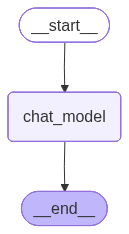

In [13]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [14]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [15]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might want to learn about:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are closely related to whales and can be found in oceans around the world. They are known for their playful behavior and complex communication.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different physical characteristics, suc

In [16]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might want to learn about:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are closely related to whales and can be found in oceans around the world. They are known for their playful behavior and complex communication.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different physical characteristics, suc

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

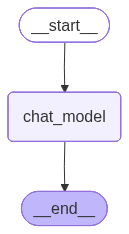

In [17]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [19]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [20]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

================================ Human Message =================================
Name: User1

Hey! I want to plan a trip to Japan next month.
================================== Ai Message ==================================
Name: Bot

That sounds exciting! Do you have specific cities in mind?
================================ Human Message =================================
Name: User1

Yes, Tokyo and Kyoto.
================================== Ai Message ==================================
Name: Bot

Great choices! How many days do you plan to stay in each city?
================================ Human Message =================================
Name: User1

3 days in Tokyo, 2 days in Kyoto.
================================== Ai Message ==================================

That sounds like a solid plan! Here’s a suggestion for your itinerary:

### Tokyo (3 Days)
**Day 1: Explore Central Tokyo**
- **Morning:** Visit the historic Asakusa district and Senso-ji Temple.
- **Afternoon:** Head to Ueno 

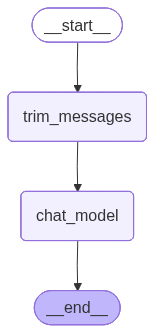

In [33]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langchain_core.messages import HumanMessage, AIMessage



llm = ChatOpenAI(model="gpt-4o-mini")


def trim_last_n(state: MessagesState, n=4):
    """
    Keep only the last `n` messages in the conversation.
    """
    return {"messages": state["messages"][-n:]}


def chat_model_node(state: MessagesState):
    """
    Pass the trimmed messages to the LLM and return the response as a new message.
    """
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


graph = StateGraph(MessagesState)

graph.add_node("trim_messages", trim_last_n)
graph.add_node("chat_model", chat_model_node)

graph.add_edge(START, "trim_messages")
graph.add_edge("trim_messages", "chat_model")
graph.add_edge("chat_model", END)

graph = graph.compile()


messages = [
    HumanMessage("Hey! I want to plan a trip to Japan next month.", name="User1", id="1"),
    AIMessage("That sounds exciting! Do you have specific cities in mind?", name="Bot", id="2"),
    HumanMessage("Yes, Tokyo and Kyoto.", name="User1", id="3"),
    AIMessage("Great choices! How many days do you plan to stay in each city?", name="Bot", id="4"),
    HumanMessage("3 days in Tokyo, 2 days in Kyoto.", name="User1", id="5"),
]


output = graph.invoke({"messages": messages})

# Print the bot's response(s)
for m in output["messages"]:
    m.pretty_print()

display(Image(graph.get_graph().draw_mermaid_png()))


Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r